In [4]:
import esig, inspect, os, sys
print("python:", sys.version)
print("esig module file:", getattr(esig, "__file__", None))
print("has __version__:", hasattr(esig, "__version__"))
print("dir(esig) head:", sorted([x for x in dir(esig) if not x.startswith('_')])[:30])

python: 3.12.12 (main, Jan 27 2026, 23:41:44) [Clang 21.1.4 ]
esig module file: /Users/kencharoff/workspace/envs/base/.venv/lib/python3.12/site-packages/esig/__init__.py
has __version__: False
dir(esig) head: ['ESIG_PACKAGE_ROOT', 'backends', 'functools', 'get_backend', 'get_library_load_error', 'get_version', 'is_library_loaded', 'list_backends', 'logsigdim', 'logsigkeys', 'math', 'numpy', 'os', 'recombine', 'set_backend', 'sigdim', 'sigkeys', 'stream2logsig', 'stream2sig', 'warnings']


Price shape: (5057, 12) Exog shape: (5057, 3)
Date range: 2006-01-03 -> 2026-02-09


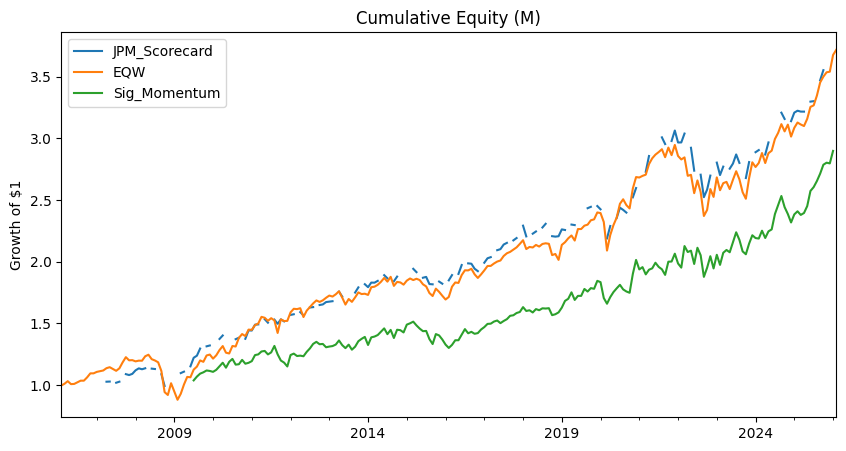

In [6]:
# ============================================
# Sig-Momentum / JPM Scorecard / EQW Backtester
# (ETF 12銘柄, Long-only, Leverage<=100%, 片道10bps)
# Rebalance: 週次 or 月次（引数で切替）
# Sig-Momentum: A方針（モーメント推定ベースの線形ℓ推定）
# デフォルト学習窓: 週次=156週, 月次=120か月
#
# Signature計算: esig (stream2sig)
# ============================================

# --- (任意) 依存パッケージのインストール ---
# !pip -q install yfinance esig scikit-learn pandas numpy matplotlib

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# =========================
# esig の import（トップレベルAPIを使用）
# =========================
try:
    import esig
    HAS_ESIG = True
except Exception as e:
    HAS_ESIG = False
    print("esig が見つかりません。Sig-Momentumを使う場合は `pip install esig` を実行してください。")
    print("error:", e)

# =========================
# 0) 設定
# =========================
TICKERS = [
    "SPY", "IWM", "EFA", "EEM",
    "AGG", "TLT", "LQD", "HYG", "EMB",
    "GLD", "DBC",
    "VNQ",
]

# 外生（yfinanceで取得しやすいもの）
EXOG_TICKERS = ["^VIX", "^TNX", "UUP"]  # VIX, 10Y proxy, USD proxy


@dataclass
class BacktestConfig:
    start: str = "2006-01-01"
    end: str = None  # Noneなら今日
    rebalance: str = "M"  # "M" or "W-FRI"
    top_k: int = 6
    cost_bps_oneway: float = 10.0  # 片道bps
    vol_lookback_days: int = 60  # ボラ推定（年率）用
    scorecard_lookbacks: Dict[str, int] = None

    # Sig-Momentum
    sig_order: int = 3
    sig_window_days_weekly: int = 126
    sig_window_days_monthly: int = 252

    # A方針学習窓（デフォルト指定）
    train_window_weeks: int = 156
    train_window_months: int = 120

    ridge_alpha: float = 10.0  # ℓ推定のリッジ強度

    # EQW
    eqw_mode: str = "ALL"  # "ALL"=12本を均等、"TOPK"=上位Kを均等（比較用）


def _default_scorecard_lookbacks():
    # 日次→「○か月」は概算で営業日換算
    return {
        "ret_3m": 63,
        "ret_6m": 126,
        "ret_12m": 252,
        "ma_5": 5,
        "ma_10": 10,
        "ma_50": 50,
        "ma_100": 100,
        "ma_200": 200,
        "ret_2w": 10,   # 2週間≒10営業日
    }


# =========================
# 1) データ取得
# =========================
def download_prices(tickers: List[str], start: str, end: Optional[str]) -> pd.DataFrame:
    px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame()
    px = px.dropna(how="all")
    px = px.ffill()
    return px


def to_returns(px: pd.DataFrame) -> pd.DataFrame:
    return px.pct_change().fillna(0.0)


# =========================
# 2) 共通ユーティリティ
# =========================
def make_rebalance_dates(px: pd.DataFrame, freq: str) -> pd.DatetimeIndex:
    freq = normalize_freq(freq)
    tmp = px.resample(freq).last()
    return tmp.index


def annualized_vol(ret_d: pd.Series, lookback: int = 60) -> float:
    r = ret_d.dropna().tail(lookback)
    if len(r) < max(10, lookback // 2):
        return np.nan
    return float(r.std(ddof=1) * np.sqrt(252))


def turnover_cost(w_old: pd.Series, w_new: pd.Series, one_way_bps: float) -> float:
    # cost = one_way * sum |Δw|
    c = (one_way_bps / 10000.0) * float(np.abs(w_new - w_old).sum())
    return c


def period_return_from_daily(ret_d: pd.DataFrame, start_dt: pd.Timestamp, end_dt: pd.Timestamp, w: pd.Series) -> float:
    # 当日終値でリバランス→翌日から反映： (start_dt, end_dt] の日次リターンを使用
    sl = ret_d.loc[(ret_d.index > start_dt) & (ret_d.index <= end_dt)]
    if sl.empty:
        return 0.0
    port_daily = sl.mul(w, axis=1).sum(axis=1)
    return float((1.0 + port_daily).prod() - 1.0)


def perf_stats(returns: pd.Series, freq: str) -> Dict[str, float]:
    r = returns.dropna()
    if r.empty:
        return {}
    f = normalize_freq(freq).upper()
    ann = 12 if f in ("M", "ME") else 52
    cagr = (1 + r).prod() ** (ann / len(r)) - 1
    vol = r.std(ddof=1) * np.sqrt(ann)
    sharpe = (r.mean() * ann) / vol if vol > 0 else np.nan
    equity = (1 + r).cumprod()
    dd = equity / equity.cummax() - 1
    max_dd = dd.min()
    return {
        "CAGR": float(cagr),
        "AnnVol": float(vol),
        "Sharpe": float(sharpe),
        "MaxDD": float(max_dd),
        "Periods": int(len(r)),
    }


def get_train_window_periods(freq: str, cfg: BacktestConfig) -> int:
    f = normalize_freq(freq).upper()
    return cfg.train_window_months if f in ("M", "ME") else cfg.train_window_weeks

def get_sig_window_days(freq: str, cfg: BacktestConfig) -> int:
    f = normalize_freq(freq).upper()
    return cfg.sig_window_days_monthly if f in ("M", "ME") else cfg.sig_window_days_weekly

def make_forward_returns(px: pd.DataFrame, rebal_dates: pd.DatetimeIndex) -> pd.DataFrame:
    p = px.reindex(rebal_dates).ffill()
    fwd = p.shift(-1) / p - 1.0
    return fwd

def normalize_freq(freq: str) -> str:
    """
    pandas >= 2.2 系のfrequency変更に対応。
    ユーザー入力は "M"/"W-FRI" を許し、内部ではpandas互換のfreqへ変換。
    """
    f = str(freq).upper()
    if f == "M":
        return "ME"      # Month End
    if f == "W":
        return "W-FRI"   # 明示しない場合は金曜
    return freq

# =========================
# 3) JPM Scorecard 戦略
# =========================
def compute_scorecard_signals(px: pd.DataFrame, ret_d: pd.DataFrame, cfg: BacktestConfig) -> Dict[pd.Timestamp, pd.Series]:
    lb = cfg.scorecard_lookbacks or _default_scorecard_lookbacks()
    rebal_dates = make_rebalance_dates(px, cfg.rebalance)

    signals = {}
    for t in rebal_dates:
        if t not in px.index:
            continue

        P = px.loc[:t]
        if len(P) < max(lb["ret_12m"], lb["ma_200"]) + 5:
            continue

        p_t = P.iloc[-1]

        def ret_n(n):
            return p_t / P.iloc[-1 - n] - 1.0

        r3m = ret_n(lb["ret_3m"])
        r6m = ret_n(lb["ret_6m"])
        r12m = ret_n(lb["ret_12m"])
        r2w = ret_n(lb["ret_2w"])

        vols = pd.Series({c: annualized_vol(ret_d[c].loc[:t], cfg.vol_lookback_days) for c in px.columns})
        vols = vols.replace([np.inf, -np.inf], np.nan)

        r3m_over = r3m / vols
        r12m_over = r12m / vols

        ma200 = P.rolling(lb["ma_200"]).mean().iloc[-1]
        ma5 = P.rolling(lb["ma_5"]).mean().iloc[-1]
        ma10 = P.rolling(lb["ma_10"]).mean().iloc[-1]
        ma100 = P.rolling(lb["ma_100"]).mean().iloc[-1]

        p_over_ma200 = p_t / ma200 - 1.0
        x_5_100 = (ma5 > ma100).astype(float)
        x_10_200 = (ma10 > ma200).astype(float)
        r6m_minus_2w = r6m - r2w

        feats = {
            "r6m": r6m,
            "r12m": r12m,
            "r3m_over": r3m_over,
            "r12m_over": r12m_over,
            "p_over_ma200": p_over_ma200,
            "x_5_100": x_5_100,
            "x_10_200": x_10_200,
            "r6m_minus_2w": r6m_minus_2w,
        }

        ranks = []
        for _, s in feats.items():
            rk = (-s).rank(method="average")  # 降順が良い
            ranks.append(rk)

        score = pd.concat(ranks, axis=1).mean(axis=1)
        signals[t] = score.sort_values()

    return signals


def weights_scorecard(px: pd.DataFrame, ret_d: pd.DataFrame, cfg: BacktestConfig,
                      signals: Dict[pd.Timestamp, pd.Series]) -> Dict[pd.Timestamp, pd.Series]:
    w_dict = {}
    for t, score in signals.items():
        top = score.index[:cfg.top_k]

        vols = pd.Series({c: annualized_vol(ret_d[c].loc[:t], cfg.vol_lookback_days) for c in px.columns})
        vols = vols.replace([np.inf, -np.inf], np.nan)

        inv = 1.0 / vols[top]
        inv = inv.replace([np.inf, -np.inf], np.nan).fillna(0.0)

        w = pd.Series(0.0, index=px.columns)
        if inv.sum() <= 0:
            w.loc[top] = 1.0 / len(top)
        else:
            w.loc[top] = inv / inv.sum()

        w_dict[t] = w

    return w_dict


# =========================
# 4) EQW 戦略
# =========================
def weights_eqw(px: pd.DataFrame, cfg: BacktestConfig,
                scorecard_signals: Optional[Dict[pd.Timestamp, pd.Series]] = None) -> Dict[pd.Timestamp, pd.Series]:
    rebal_dates = make_rebalance_dates(px, cfg.rebalance)
    w_dict = {}

    for t in rebal_dates:
        w = pd.Series(0.0, index=px.columns)
        if cfg.eqw_mode == "ALL":
            w.loc[:] = 1.0 / len(px.columns)
        elif cfg.eqw_mode == "TOPK":
            if scorecard_signals is None or t not in scorecard_signals:
                continue
            top = scorecard_signals[t].index[:cfg.top_k]
            w.loc[top] = 1.0 / len(top)
        else:
            raise ValueError("eqw_mode must be 'ALL' or 'TOPK'")
        w_dict[t] = w

    return w_dict


# =========================
# 5) Sig-Momentum（signature + A方式ℓ推定）
# =========================
def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()


def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    up = np.maximum(delta, 0.0)
    down = np.maximum(-delta, 0.0)
    roll_up = pd.Series(up, index=series.index).ewm(alpha=1/period, adjust=False).mean()
    roll_down = pd.Series(down, index=series.index).ewm(alpha=1/period, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100.0 - (100.0 / (1.0 + rs))


def macd(series: pd.Series, fast=12, slow=26, signal=9) -> Tuple[pd.Series, pd.Series, pd.Series]:
    m_fast = ema(series, fast)
    m_slow = ema(series, slow)
    macd_line = m_fast - m_slow
    sig_line = ema(macd_line, signal)
    hist = macd_line - sig_line
    return macd_line, sig_line, hist


def simple_kalman_trend(series: pd.Series, q: float = 1e-5, r: float = 1e-3) -> Tuple[pd.Series, pd.Series]:
    y = series.values.astype(float)
    n = len(y)
    x_hat = np.zeros(n)
    p = 1.0
    x = y[0] if n > 0 else 0.0
    for t in range(n):
        p = p + q
        k = p / (p + r)
        x = x + k * (y[t] - x)
        p = (1 - k) * p
        x_hat[t] = x
    x_hat = pd.Series(x_hat, index=series.index)
    trend = x_hat.diff().fillna(0.0)
    return x_hat, trend


def build_channels_for_asset(px_asset: pd.Series, ret_asset: pd.Series,
                             exog_ret: pd.DataFrame) -> pd.DataFrame:
    P = px_asset
    r = ret_asset

    ret_63 = P.pct_change(63)
    ret_126 = P.pct_change(126)
    ret_252 = P.pct_change(252)

    ma50 = P.rolling(50).mean()
    ma200 = P.rolling(200).mean()
    p_ma50 = P / ma50 - 1.0
    p_ma200 = P / ma200 - 1.0

    ma5 = P.rolling(5).mean()
    ma10 = P.rolling(10).mean()
    ma100 = P.rolling(100).mean()
    x_5_100 = (ma5 > ma100).astype(float)
    x_10_200 = (ma10 > ma200).astype(float)

    macd_line, sig_line, hist = macd(P)
    rsi14 = rsi(P, 14)

    vol60 = r.rolling(60).std(ddof=1) * np.sqrt(252)
    ret2vol_126 = ret_126 / (vol60 + 1e-12)
    invvol = 1.0 / (vol60 + 1e-12)

    kf_level, kf_trend = simple_kalman_trend(P)

    df = pd.DataFrame({
        "r": r,
        "ret_63": ret_63,
        "ret_126": ret_126,
        "ret_252": ret_252,
        "p_ma50": p_ma50,
        "p_ma200": p_ma200,
        "x_5_100": x_5_100,
        "x_10_200": x_10_200,
        "macd": macd_line,
        "macd_sig": sig_line,
        "macd_hist": hist,
        "rsi14": rsi14,
        "vol60": vol60,
        "ret2vol_126": ret2vol_126,
        "invvol": invvol,
        "kf_level": kf_level,
        "kf_trend": kf_trend,
    })

    for c in exog_ret.columns:
        df[f"exog_{c}"] = exog_ret[c]

    df = df.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return df


def time_augment(df: pd.DataFrame) -> np.ndarray:
    T = len(df)
    if T <= 1:
        t = np.zeros((T, 1))
    else:
        t = np.linspace(0.0, 1.0, T).reshape(-1, 1)
    X = df.values
    return np.concatenate([t, X], axis=1)

def signature_features_esig(path: np.ndarray, order: int) -> np.ndarray:
    """
    esig: トップレベルAPI stream2sig を使用（tosig submoduleは使わない）
    path: shape (T, m)
    """
    if not HAS_ESIG:
        raise RuntimeError("esig is required for signature features.")
    sig = esig.stream2sig(path.astype(np.float64), order)
    return np.asarray(sig, dtype=float)

def build_sig_features_all(px: pd.DataFrame, ret_d: pd.DataFrame,
                           exog_px: pd.DataFrame, cfg: BacktestConfig) -> Tuple[Dict[Tuple[pd.Timestamp, str], np.ndarray], pd.DatetimeIndex]:
    rebal_dates = make_rebalance_dates(px, cfg.rebalance)
    sig_days = get_sig_window_days(cfg.rebalance, cfg)

    exog_ret = to_returns(exog_px).reindex(px.index).ffill().fillna(0.0)

    sig_feat: Dict[Tuple[pd.Timestamp, str], np.ndarray] = {}

    for t in rebal_dates:
        idx = px.index.get_indexer([t], method="ffill")[0]
        # 指標に長期窓（252/200等）があるので余裕を持つ
        if idx < sig_days + 260:
            continue

        start_idx = max(0, idx - sig_days + 1)
        window_index = px.index[start_idx: idx + 1]
        exog_ret_w = exog_ret.loc[window_index]

        for asset in px.columns:
            P = px[asset].loc[window_index]
            r = ret_d[asset].loc[window_index]
            ch = build_channels_for_asset(P, r, exog_ret_w)

            path = time_augment(ch)
            feat = signature_features_esig(path, cfg.sig_order)
            sig_feat[(t, asset)] = feat

    return sig_feat, rebal_dates


def fit_l_for_time(t_idx: int,
                   rebal_dates: pd.DatetimeIndex,
                   sig_feat_by_time_asset: Dict[Tuple[pd.Timestamp, str], np.ndarray],
                   fwd_ret: pd.DataFrame,
                   cfg: BacktestConfig,
                   scaler: Optional[StandardScaler]) -> Tuple[np.ndarray, StandardScaler]:
    train_periods = get_train_window_periods(cfg.rebalance, cfg)
    start = max(0, t_idx - train_periods)
    end = t_idx  # exclude current

    X_list = []
    y_list = []

    for j in range(start, end):
        tj = rebal_dates[j]
        y_row = fwd_ret.loc[tj]
        if y_row.isna().all():
            continue
        for asset in fwd_ret.columns:
            key = (tj, asset)
            if key not in sig_feat_by_time_asset:
                continue
            X_list.append(sig_feat_by_time_asset[key])
            y_list.append(float(y_row[asset]))

    if len(X_list) < 200:
        raise RuntimeError("学習データが不足しています。開始日を後ろにずらすか、window/trainを短くしてください。")

    X = np.vstack(X_list)
    y = np.array(y_list)

    if scaler is None:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xs = scaler.fit_transform(X)
    else:
        Xs = scaler.fit_transform(X)  # ローリング比較用途：毎回fitでOK

    model = Ridge(alpha=cfg.ridge_alpha, fit_intercept=True, random_state=0)
    model.fit(Xs, y)
    l = model.coef_.astype(float)
    return l, scaler


def weights_sig_momentum(px: pd.DataFrame, ret_d: pd.DataFrame, cfg: BacktestConfig,
                         sig_feat: Dict[Tuple[pd.Timestamp, str], np.ndarray],
                         rebal_dates: pd.DatetimeIndex,
                         fwd_ret: pd.DataFrame) -> Dict[pd.Timestamp, pd.Series]:
    w_dict: Dict[pd.Timestamp, pd.Series] = {}
    scaler = None

    for t_idx, t in enumerate(rebal_dates[:-1]):
        try:
            l, scaler = fit_l_for_time(t_idx, rebal_dates, sig_feat, fwd_ret, cfg, scaler)
        except Exception:
            continue

        scores = {}
        for asset in px.columns:
            key = (t, asset)
            if key not in sig_feat:
                continue
            x = sig_feat[key].reshape(1, -1)
            x = scaler.transform(x)
            s = float(np.dot(l, x.ravel()))
            scores[asset] = s

        if len(scores) < cfg.top_k:
            continue

        srs = pd.Series(scores).sort_values(ascending=False)
        top = srs.index[:cfg.top_k]

        vols = pd.Series({c: annualized_vol(ret_d[c].loc[:t], cfg.vol_lookback_days) for c in px.columns})
        vols = vols.replace([np.inf, -np.inf], np.nan)

        raw = np.maximum(srs[top].values, 0.0)  # ロングオンリー写像
        invvol = 1.0 / (vols[top].values + 1e-12)
        tilt = raw * invvol

        if np.sum(tilt) <= 0:
            tilt = invvol.copy()

        w = pd.Series(0.0, index=px.columns)
        w.loc[top] = tilt / np.sum(tilt)
        w_dict[t] = w

    return w_dict


# =========================
# 6) バックテスト実行
# =========================
def run_backtest(px: pd.DataFrame, ret_d: pd.DataFrame, cfg: BacktestConfig,
                 weights_by_time: Dict[pd.Timestamp, pd.Series]) -> pd.Series:
    rebal_dates = make_rebalance_dates(px, cfg.rebalance)
    rebal_dates = [d for d in rebal_dates if d in weights_by_time]
    rebal_dates = pd.DatetimeIndex(rebal_dates)
    if len(rebal_dates) < 3:
        raise RuntimeError("有効なリバランス日が不足しています。")

    one_way_bps = cfg.cost_bps_oneway
    w_prev = pd.Series(0.0, index=px.columns)

    period_rets = []
    period_idx = []

    for i in range(len(rebal_dates) - 1):
        t = rebal_dates[i]
        t_next = rebal_dates[i + 1]

        w_new = weights_by_time[t].reindex(px.columns).fillna(0.0)

        cost = turnover_cost(w_prev, w_new, one_way_bps)
        r = period_return_from_daily(ret_d, t, t_next, w_new)
        r_adj = (1.0 + r) * (1.0 - cost) - 1.0

        period_rets.append(r_adj)
        period_idx.append(t_next)

        w_prev = w_new.copy()

    return pd.Series(period_rets, index=pd.DatetimeIndex(period_idx), name="period_return")


# =========================
# 7) 実行例（ノートブックでここから）
# =========================
cfg = BacktestConfig(
    start="2006-01-01",
    end=None,
    rebalance="M",          # "M" or "W-FRI"
    top_k=6,
    cost_bps_oneway=10.0,
    vol_lookback_days=60,
    sig_order=3,
    train_window_weeks=156,   # ★デフォルト（週次）
    train_window_months=120,  # ★デフォルト（月次）
    ridge_alpha=10.0,
    eqw_mode="ALL",         # EQW: 全12本均等（素直な基準）
)

if cfg.scorecard_lookbacks is None:
    cfg.scorecard_lookbacks = _default_scorecard_lookbacks()

# 7.1 データ取得
px = download_prices(TICKERS, cfg.start, cfg.end)
ret_d = to_returns(px)

exog_px = download_prices(EXOG_TICKERS, cfg.start, cfg.end)

print("Price shape:", px.shape, "Exog shape:", exog_px.shape)
print("Date range:", px.index.min().date(), "->", px.index.max().date())

# 7.2 JPM Scorecard
score_signals = compute_scorecard_signals(px, ret_d, cfg)
w_scorecard = weights_scorecard(px, ret_d, cfg, score_signals)
r_scorecard = run_backtest(px, ret_d, cfg, w_scorecard)

# 7.3 EQW
w_eqw = weights_eqw(px, cfg, scorecard_signals=score_signals)
r_eqw = run_backtest(px, ret_d, cfg, w_eqw)

# 7.4 Sig-Momentum（esigが使える場合のみ）
if HAS_ESIG:
    sig_feat, rebal_dates = build_sig_features_all(px, ret_d, exog_px, cfg)
    fwd_ret = make_forward_returns(px, rebal_dates)
    w_sig = weights_sig_momentum(px, ret_d, cfg, sig_feat, rebal_dates, fwd_ret)
    r_sig = run_backtest(px, ret_d, cfg, w_sig)
else:
    r_sig = None

# 7.5 統計
stats = {
    "JPM_Scorecard": perf_stats(r_scorecard, cfg.rebalance),
    "EQW": perf_stats(r_eqw, cfg.rebalance),
}
if r_sig is not None:
    stats["Sig_Momentum"] = perf_stats(r_sig, cfg.rebalance)

pd.DataFrame(stats).T

# 7.6 プロット（累積）
equity = pd.DataFrame({
    "JPM_Scorecard": (1+r_scorecard).cumprod(),
    "EQW": (1+r_eqw).cumprod(),
})
if r_sig is not None:
    equity["Sig_Momentum"] = (1+r_sig).cumprod()

ax = equity.plot(title=f"Cumulative Equity ({cfg.rebalance})", figsize=(10,5))
ax.set_ylabel("Growth of $1")
plt.show()

# 7.7 週次/月次の切替
# cfg.rebalance = "W-FRI" に変更して、7.2〜7.6 を再実行してください。

Price shape: (5057, 12) Exog shape: (5057, 3)
Date range: 2006-01-03 -> 2026-02-09
Rebalance freq (user): M -> internal: ME


,CAGR,AnnVol,Sharpe,MaxDD,HitRate,Skew,Kurtosis,Periods,AvgTurnover,AvgCost,TotalCost
JPM_Scorecard,0.101078,0.102931,0.989910,-0.176421,0.668750,0.219004,5.614612,160.0,0.540162,0.000540,0.086426
Sig_Momentum,0.066261,0.098744,0.700415,-0.140877,0.628141,-0.037073,0.391355,199.0,1.458606,0.001459,0.290263
EQW,0.067585,0.103346,0.686601,-0.293443,0.634855,-0.739856,3.977647,241.0,0.004149,0.000004,0.001000


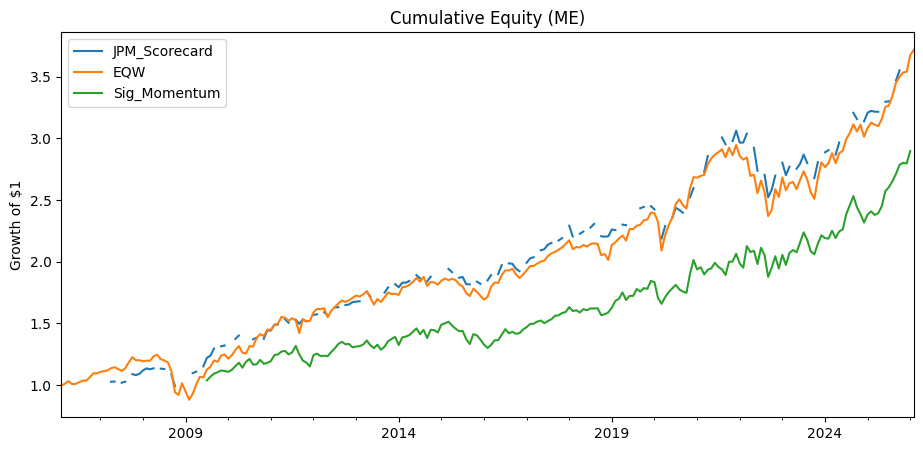

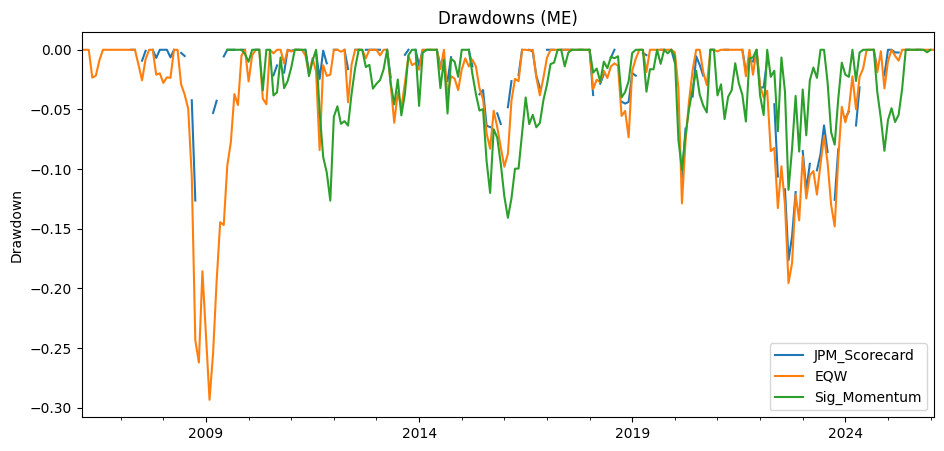

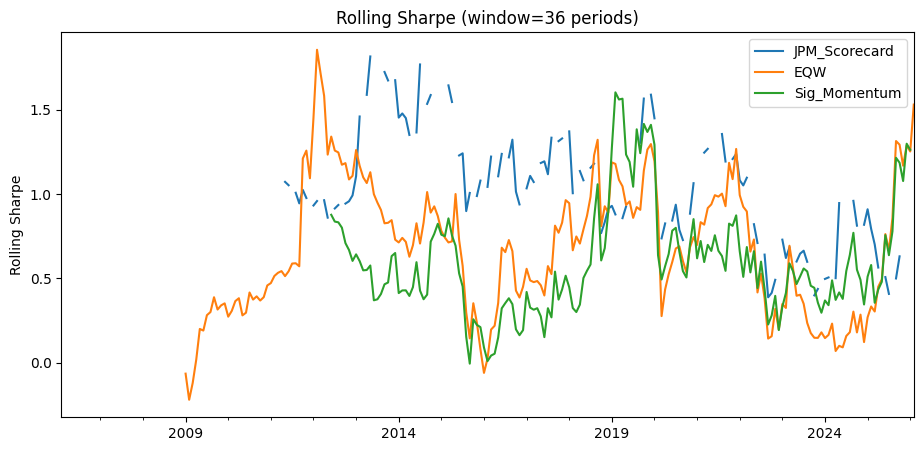


==== Subperiod stats: JPM_Scorecard ====


,CAGR,AnnVol,Sharpe,MaxDD,HitRate,Skew,Kurtosis,Periods
2006-2009,0.142566,0.158674,0.917783,-0.126377,0.640000,1.214720,5.252199,25.0
2010-2019,0.092409,0.070454,1.293906,-0.064804,0.702381,-0.439045,0.633555,84.0
2020-2021,0.182088,0.131013,1.348925,-0.097224,0.687500,-1.822119,4.337606,16.0
2022-Now,0.058008,0.107646,0.577776,-0.169737,0.600000,-0.644891,-0.216407,35.0



==== Subperiod stats: EQW ====


,CAGR,AnnVol,Sharpe,MaxDD,HitRate,Skew,Kurtosis,Periods
2006-2009,0.057842,0.142365,0.467487,-0.293443,0.638298,-1.050232,4.454650,47.0
2010-2019,0.067659,0.077314,0.887277,-0.098058,0.625000,-0.053083,1.189364,120.0
2020-2021,0.108252,0.119076,0.924966,-0.126872,0.666667,-1.167252,3.321044,24.0
2022-Now,0.057500,0.109730,0.564554,-0.170318,0.640000,-0.289105,-0.059894,50.0



==== Subperiod stats: Sig_Momentum ====


,CAGR,AnnVol,Sharpe,MaxDD,HitRate,Skew,Kurtosis,Periods
2006-2009,0.239529,0.050568,4.305371,-0.003619,0.833333,-0.271606,-0.548375,6.0
2010-2019,0.051769,0.083569,0.646553,-0.140877,0.650000,-0.038359,0.164814,120.0
2020-2021,0.057984,0.119836,0.528308,-0.095384,0.541667,0.298145,0.627573,24.0
2022-Now,0.086599,0.124258,0.731482,-0.117423,0.591837,-0.210354,-0.219395,49.0


In [7]:
# ============================================
# JPM Scorecard / Sig-Momentum(esig) / EQW Backtester
# Universe: 12 ETFs
# Constraints: Long-only, Leverage<=100% (full invest), cost=10bps one-way
# Rebalance: Weekly or Monthly (arg switch)
# Sig-Momentum: A方針（signature特徴のモーメント推定に基づく線形ℓ推定）
# Default train window: weekly=156 weeks, monthly=120 months
# Signature: esig.stream2sig (TOP-LEVEL API)  <-- important fix
# ============================================

# ---- (optional) install deps in notebook ----
# !pip -q install yfinance esig scikit-learn pandas numpy matplotlib

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# =========================
# 0) esig import (TOP-LEVEL)
# =========================
try:
    import esig
    HAS_ESIG = True
except Exception as e:
    HAS_ESIG = False
    print("esig import failed. Install with: pip install esig")
    print("error:", e)


# =========================
# 1) Settings
# =========================
TICKERS = [
    "SPY", "IWM", "EFA", "EEM",
    "AGG", "TLT", "LQD", "HYG", "EMB",
    "GLD", "DBC",
    "VNQ",
]

# exogenous series (yfinance)
EXOG_TICKERS = ["^VIX", "^TNX", "UUP"]  # VIX, 10Y proxy, USD proxy


@dataclass
class BacktestConfig:
    start: str = "2006-01-01"
    end: Optional[str] = None  # None => today
    rebalance: str = "M"       # "M" or "W-FRI" (user-friendly). Internally normalized.
    top_k: int = 6

    cost_bps_oneway: float = 10.0
    vol_lookback_days: int = 60

    # Scorecard lookbacks (business days)
    scorecard_lookbacks: Optional[Dict[str, int]] = None

    # Sig-Momentum
    sig_order: int = 3
    sig_window_days_weekly: int = 126   # ~6m
    sig_window_days_monthly: int = 252  # ~12m

    # Rolling train window (default as requested)
    train_window_weeks: int = 156
    train_window_months: int = 120

    ridge_alpha: float = 10.0

    # EQW
    eqw_mode: str = "ALL"  # "ALL"=equal-weight all 12, "TOPK"=equal-weight top_k by scorecard

    # Trading convention: rebalance at close t, positions active from next day
    active_from_next_day: bool = True


def _default_scorecard_lookbacks():
    return {
        "ret_3m": 63,
        "ret_6m": 126,
        "ret_12m": 252,
        "ma_5": 5,
        "ma_10": 10,
        "ma_50": 50,
        "ma_100": 100,
        "ma_200": 200,
        "ret_2w": 10,
    }


# =========================
# 2) Freq normalization (pandas >=2.2)
# =========================
def normalize_freq(freq: str) -> str:
    f = str(freq).upper().strip()
    if f == "M":
        return "ME"      # Month End
    if f == "W":
        return "W-FRI"
    return freq


def is_monthly(freq: str) -> bool:
    f = normalize_freq(freq).upper()
    return f in ("M", "ME")


# =========================
# 3) Data
# =========================
def download_prices(tickers: List[str], start: str, end: Optional[str]) -> pd.DataFrame:
    px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame()
    px = px.dropna(how="all").ffill()
    return px


def to_returns(px: pd.DataFrame) -> pd.DataFrame:
    return px.pct_change().fillna(0.0)


# =========================
# 4) Common utils
# =========================
def make_rebalance_dates(px: pd.DataFrame, freq: str) -> pd.DatetimeIndex:
    freq_n = normalize_freq(freq)
    return px.resample(freq_n).last().index


def annualized_vol(ret_d: pd.Series, lookback: int = 60) -> float:
    r = ret_d.dropna().tail(lookback)
    if len(r) < max(10, lookback // 2):
        return np.nan
    return float(r.std(ddof=1) * np.sqrt(252))


def turnover_cost(w_old: pd.Series, w_new: pd.Series, one_way_bps: float) -> float:
    return (one_way_bps / 10000.0) * float(np.abs(w_new - w_old).sum())


def period_return_from_daily(
    ret_d: pd.DataFrame,
    start_dt: pd.Timestamp,
    end_dt: pd.Timestamp,
    w: pd.Series,
    active_from_next_day: bool = True
) -> float:
    if active_from_next_day:
        sl = ret_d.loc[(ret_d.index > start_dt) & (ret_d.index <= end_dt)]
    else:
        sl = ret_d.loc[(ret_d.index >= start_dt) & (ret_d.index <= end_dt)]
    if sl.empty:
        return 0.0
    port_daily = sl.mul(w, axis=1).sum(axis=1)
    return float((1.0 + port_daily).prod() - 1.0)


def equity_curve(returns: pd.Series) -> pd.Series:
    return (1.0 + returns.fillna(0.0)).cumprod()


def max_drawdown(equity: pd.Series) -> float:
    dd = equity / equity.cummax() - 1.0
    return float(dd.min())


def perf_stats(returns: pd.Series, freq: str) -> Dict[str, float]:
    r = returns.dropna()
    if r.empty:
        return {}
    ann = 12 if is_monthly(freq) else 52
    cagr = (1 + r).prod() ** (ann / len(r)) - 1
    vol = r.std(ddof=1) * np.sqrt(ann)
    sharpe = (r.mean() * ann) / vol if vol > 0 else np.nan
    eq = equity_curve(r)
    mdd = max_drawdown(eq)
    hit = float((r > 0).mean())
    skew = float(r.skew())
    kurt = float(r.kurtosis())
    return {
        "CAGR": float(cagr),
        "AnnVol": float(vol),
        "Sharpe": float(sharpe),
        "MaxDD": float(mdd),
        "HitRate": float(hit),
        "Skew": float(skew),
        "Kurtosis": float(kurt),
        "Periods": int(len(r)),
    }


def rolling_sharpe(returns: pd.Series, freq: str, window_periods: int) -> pd.Series:
    ann = 12 if is_monthly(freq) else 52
    r = returns.dropna()
    mu = r.rolling(window_periods).mean() * ann
    sd = r.rolling(window_periods).std(ddof=1) * np.sqrt(ann)
    return mu / sd


# =========================
# 5) JPM Scorecard
# =========================
def compute_scorecard_signals(px: pd.DataFrame, ret_d: pd.DataFrame, cfg: BacktestConfig) -> Dict[pd.Timestamp, pd.Series]:
    lb = cfg.scorecard_lookbacks or _default_scorecard_lookbacks()
    rebal_dates = make_rebalance_dates(px, cfg.rebalance)

    signals: Dict[pd.Timestamp, pd.Series] = {}
    for t in rebal_dates:
        if t not in px.index:
            continue
        P = px.loc[:t]
        if len(P) < max(lb["ret_12m"], lb["ma_200"]) + 5:
            continue

        p_t = P.iloc[-1]

        def ret_n(n):
            return p_t / P.iloc[-1 - n] - 1.0

        r3m = ret_n(lb["ret_3m"])
        r6m = ret_n(lb["ret_6m"])
        r12m = ret_n(lb["ret_12m"])
        r2w = ret_n(lb["ret_2w"])

        vols = pd.Series({c: annualized_vol(ret_d[c].loc[:t], cfg.vol_lookback_days) for c in px.columns})
        vols = vols.replace([np.inf, -np.inf], np.nan)

        r3m_over = r3m / vols
        r12m_over = r12m / vols

        ma200 = P.rolling(lb["ma_200"]).mean().iloc[-1]
        ma5 = P.rolling(lb["ma_5"]).mean().iloc[-1]
        ma10 = P.rolling(lb["ma_10"]).mean().iloc[-1]
        ma100 = P.rolling(lb["ma_100"]).mean().iloc[-1]

        p_over_ma200 = p_t / ma200 - 1.0
        x_5_100 = (ma5 > ma100).astype(float)
        x_10_200 = (ma10 > ma200).astype(float)
        r6m_minus_2w = r6m - r2w

        feats = {
            "r6m": r6m,
            "r12m": r12m,
            "r3m_over": r3m_over,
            "r12m_over": r12m_over,
            "p_over_ma200": p_over_ma200,
            "x_5_100": x_5_100,
            "x_10_200": x_10_200,
            "r6m_minus_2w": r6m_minus_2w,
        }

        ranks = []
        for s in feats.values():
            ranks.append((-s).rank(method="average"))  # higher is better -> rank by negative
        score = pd.concat(ranks, axis=1).mean(axis=1)
        signals[t] = score.sort_values()  # smaller is better

    return signals


def weights_scorecard(px: pd.DataFrame, ret_d: pd.DataFrame, cfg: BacktestConfig,
                      signals: Dict[pd.Timestamp, pd.Series]) -> Dict[pd.Timestamp, pd.Series]:
    w_dict: Dict[pd.Timestamp, pd.Series] = {}
    for t, score in signals.items():
        top = score.index[:cfg.top_k]
        vols = pd.Series({c: annualized_vol(ret_d[c].loc[:t], cfg.vol_lookback_days) for c in px.columns})
        vols = vols.replace([np.inf, -np.inf], np.nan)

        inv = 1.0 / vols[top]
        inv = inv.replace([np.inf, -np.inf], np.nan).fillna(0.0)

        w = pd.Series(0.0, index=px.columns)
        if inv.sum() <= 0:
            w.loc[top] = 1.0 / len(top)
        else:
            w.loc[top] = inv / inv.sum()

        w_dict[t] = w
    return w_dict


# =========================
# 6) EQW
# =========================
def weights_eqw(px: pd.DataFrame, cfg: BacktestConfig,
                scorecard_signals: Optional[Dict[pd.Timestamp, pd.Series]] = None) -> Dict[pd.Timestamp, pd.Series]:
    rebal_dates = make_rebalance_dates(px, cfg.rebalance)
    w_dict: Dict[pd.Timestamp, pd.Series] = {}

    for t in rebal_dates:
        w = pd.Series(0.0, index=px.columns)
        if cfg.eqw_mode == "ALL":
            w.loc[:] = 1.0 / len(px.columns)
        elif cfg.eqw_mode == "TOPK":
            if scorecard_signals is None or t not in scorecard_signals:
                continue
            top = scorecard_signals[t].index[:cfg.top_k]
            w.loc[top] = 1.0 / len(top)
        else:
            raise ValueError("eqw_mode must be 'ALL' or 'TOPK'")
        w_dict[t] = w
    return w_dict


# =========================
# 7) Sig-Momentum (esig)
# =========================
def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()


def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    up = np.maximum(delta, 0.0)
    down = np.maximum(-delta, 0.0)
    roll_up = pd.Series(up, index=series.index).ewm(alpha=1/period, adjust=False).mean()
    roll_down = pd.Series(down, index=series.index).ewm(alpha=1/period, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100.0 - (100.0 / (1.0 + rs))


def macd(series: pd.Series, fast=12, slow=26, signal=9) -> Tuple[pd.Series, pd.Series, pd.Series]:
    m_fast = ema(series, fast)
    m_slow = ema(series, slow)
    macd_line = m_fast - m_slow
    sig_line = ema(macd_line, signal)
    hist = macd_line - sig_line
    return macd_line, sig_line, hist


def simple_kalman_trend(series: pd.Series, q: float = 1e-5, r: float = 1e-3) -> Tuple[pd.Series, pd.Series]:
    y = series.values.astype(float)
    n = len(y)
    x_hat = np.zeros(n)
    p = 1.0
    x = y[0] if n > 0 else 0.0
    for t in range(n):
        p = p + q
        k = p / (p + r)
        x = x + k * (y[t] - x)
        p = (1 - k) * p
        x_hat[t] = x
    x_hat = pd.Series(x_hat, index=series.index)
    trend = x_hat.diff().fillna(0.0)
    return x_hat, trend


def build_channels_for_asset(px_asset: pd.Series, ret_asset: pd.Series, exog_ret: pd.DataFrame) -> pd.DataFrame:
    P = px_asset
    r = ret_asset

    ret_63 = P.pct_change(63)
    ret_126 = P.pct_change(126)
    ret_252 = P.pct_change(252)

    ma50 = P.rolling(50).mean()
    ma200 = P.rolling(200).mean()
    p_ma50 = P / ma50 - 1.0
    p_ma200 = P / ma200 - 1.0

    ma5 = P.rolling(5).mean()
    ma10 = P.rolling(10).mean()
    ma100 = P.rolling(100).mean()
    x_5_100 = (ma5 > ma100).astype(float)
    x_10_200 = (ma10 > ma200).astype(float)

    macd_line, sig_line, hist = macd(P)
    rsi14 = rsi(P, 14)

    vol60 = r.rolling(60).std(ddof=1) * np.sqrt(252)
    ret2vol_126 = ret_126 / (vol60 + 1e-12)
    invvol = 1.0 / (vol60 + 1e-12)

    kf_level, kf_trend = simple_kalman_trend(P)

    df = pd.DataFrame({
        "r": r,
        "ret_63": ret_63,
        "ret_126": ret_126,
        "ret_252": ret_252,
        "p_ma50": p_ma50,
        "p_ma200": p_ma200,
        "x_5_100": x_5_100,
        "x_10_200": x_10_200,
        "macd": macd_line,
        "macd_sig": sig_line,
        "macd_hist": hist,
        "rsi14": rsi14,
        "vol60": vol60,
        "ret2vol_126": ret2vol_126,
        "invvol": invvol,
        "kf_level": kf_level,
        "kf_trend": kf_trend,
    })

    # Exogenous: returns of VIX/TNX/UUP etc (common regime info)
    for c in exog_ret.columns:
        df[f"exog_{c}"] = exog_ret[c]

    return df.replace([np.inf, -np.inf], np.nan).fillna(0.0)


def time_augment(df: pd.DataFrame) -> np.ndarray:
    T = len(df)
    t = np.linspace(0.0, 1.0, T).reshape(-1, 1) if T > 1 else np.zeros((T, 1))
    X = df.values
    return np.concatenate([t, X], axis=1)


def signature_features_esig(path: np.ndarray, order: int) -> np.ndarray:
    """
    esig TOP-LEVEL API
    """
    if not HAS_ESIG:
        raise RuntimeError("esig is required for signature features.")
    sig = esig.stream2sig(path.astype(np.float64), order)
    return np.asarray(sig, dtype=float)


def get_train_window_periods(cfg: BacktestConfig) -> int:
    return cfg.train_window_months if is_monthly(cfg.rebalance) else cfg.train_window_weeks


def get_sig_window_days(cfg: BacktestConfig) -> int:
    return cfg.sig_window_days_monthly if is_monthly(cfg.rebalance) else cfg.sig_window_days_weekly


def make_forward_returns(px: pd.DataFrame, rebal_dates: pd.DatetimeIndex) -> pd.DataFrame:
    p = px.reindex(rebal_dates).ffill()
    return p.shift(-1) / p - 1.0


def build_sig_features_all(px: pd.DataFrame, ret_d: pd.DataFrame, exog_px: pd.DataFrame, cfg: BacktestConfig
                           ) -> Tuple[Dict[Tuple[pd.Timestamp, str], np.ndarray], pd.DatetimeIndex]:
    rebal_dates = make_rebalance_dates(px, cfg.rebalance)
    sig_days = get_sig_window_days(cfg)

    # exog returns aligned to px dates
    exog_ret = to_returns(exog_px).reindex(px.index).ffill().fillna(0.0)

    sig_feat: Dict[Tuple[pd.Timestamp, str], np.ndarray] = {}

    for t in rebal_dates:
        idx = px.index.get_indexer([t], method="ffill")[0]
        # need extra history for long indicators (252/200)
        if idx < sig_days + 260:
            continue

        start_idx = max(0, idx - sig_days + 1)
        window_index = px.index[start_idx: idx + 1]
        exog_ret_w = exog_ret.loc[window_index]

        for asset in px.columns:
            P = px[asset].loc[window_index]
            r = ret_d[asset].loc[window_index]
            ch = build_channels_for_asset(P, r, exog_ret_w)
            path = time_augment(ch)
            feat = signature_features_esig(path, cfg.sig_order)
            sig_feat[(t, asset)] = feat

    return sig_feat, rebal_dates


def fit_l_for_time(
    t_idx: int,
    rebal_dates: pd.DatetimeIndex,
    sig_feat_by_time_asset: Dict[Tuple[pd.Timestamp, str], np.ndarray],
    fwd_ret: pd.DataFrame,
    cfg: BacktestConfig
) -> Tuple[np.ndarray, StandardScaler]:
    train_periods = get_train_window_periods(cfg)
    start = max(0, t_idx - train_periods)
    end = t_idx

    X_list = []
    y_list = []

    for j in range(start, end):
        tj = rebal_dates[j]
        y_row = fwd_ret.loc[tj]
        if y_row.isna().all():
            continue
        for asset in fwd_ret.columns:
            key = (tj, asset)
            if key not in sig_feat_by_time_asset:
                continue
            X_list.append(sig_feat_by_time_asset[key])
            y_list.append(float(y_row[asset]))

    if len(X_list) < 200:
        raise RuntimeError("Insufficient training samples. Move start later or shorten windows.")

    X = np.vstack(X_list)
    y = np.array(y_list)

    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X)

    model = Ridge(alpha=cfg.ridge_alpha, fit_intercept=True, random_state=0)
    model.fit(Xs, y)
    l = model.coef_.astype(float)
    return l, scaler


def weights_sig_momentum(
    px: pd.DataFrame, ret_d: pd.DataFrame, cfg: BacktestConfig,
    sig_feat: Dict[Tuple[pd.Timestamp, str], np.ndarray],
    rebal_dates: pd.DatetimeIndex,
    fwd_ret: pd.DataFrame
) -> Dict[pd.Timestamp, pd.Series]:
    w_dict: Dict[pd.Timestamp, pd.Series] = {}

    for t_idx, t in enumerate(rebal_dates[:-1]):  # last has no forward return
        try:
            l, scaler = fit_l_for_time(t_idx, rebal_dates, sig_feat, fwd_ret, cfg)
        except Exception:
            continue

        # scores for all assets
        scores = {}
        for asset in px.columns:
            key = (t, asset)
            if key not in sig_feat:
                continue
            x = sig_feat[key].reshape(1, -1)
            x = scaler.transform(x)
            s = float(np.dot(l, x.ravel()))
            scores[asset] = s

        if len(scores) < cfg.top_k:
            continue

        srs = pd.Series(scores).sort_values(ascending=False)
        top = srs.index[:cfg.top_k]

        vols = pd.Series({c: annualized_vol(ret_d[c].loc[:t], cfg.vol_lookback_days) for c in px.columns})
        vols = vols.replace([np.inf, -np.inf], np.nan)

        # long-only mapping + risk scaling
        raw = np.maximum(srs[top].values, 0.0)
        invvol = 1.0 / (vols[top].values + 1e-12)
        tilt = raw * invvol

        if np.sum(tilt) <= 0:
            tilt = invvol.copy()

        w = pd.Series(0.0, index=px.columns)
        w.loc[top] = tilt / np.sum(tilt)
        w_dict[t] = w

    return w_dict


# =========================
# 8) Backtest runner (returns + turnover + cost series)
# =========================
def run_backtest(
    px: pd.DataFrame, ret_d: pd.DataFrame, cfg: BacktestConfig,
    weights_by_time: Dict[pd.Timestamp, pd.Series]
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    rebal_dates = make_rebalance_dates(px, cfg.rebalance)
    rebal_dates = [d for d in rebal_dates if d in weights_by_time]
    rebal_dates = pd.DatetimeIndex(rebal_dates)
    if len(rebal_dates) < 3:
        raise RuntimeError("Not enough rebalance dates with valid weights.")

    w_prev = pd.Series(0.0, index=px.columns)

    rets = []
    turns = []
    costs = []
    idxs = []

    for i in range(len(rebal_dates) - 1):
        t = rebal_dates[i]
        t_next = rebal_dates[i + 1]

        w_new = weights_by_time[t].reindex(px.columns).fillna(0.0)

        to = float(np.abs(w_new - w_prev).sum())
        cost = turnover_cost(w_prev, w_new, cfg.cost_bps_oneway)
        r = period_return_from_daily(ret_d, t, t_next, w_new, active_from_next_day=cfg.active_from_next_day)

        r_adj = (1.0 + r) * (1.0 - cost) - 1.0

        rets.append(r_adj)
        turns.append(to)
        costs.append(cost)
        idxs.append(t_next)

        w_prev = w_new.copy()

    return (
        pd.Series(rets, index=pd.DatetimeIndex(idxs), name="period_return"),
        pd.Series(turns, index=pd.DatetimeIndex(idxs), name="turnover"),
        pd.Series(costs, index=pd.DatetimeIndex(idxs), name="cost")
    )


# =========================
# 9) Evaluation helpers
# =========================
def summarize_strategies(results: Dict[str, Dict[str, pd.Series]], cfg: BacktestConfig) -> pd.DataFrame:
    rows = {}
    for name, d in results.items():
        r = d["returns"]
        to = d["turnover"]
        cs = d["cost"]

        st = perf_stats(r, cfg.rebalance)
        # avg turnover / avg cost per period
        st["AvgTurnover"] = float(to.mean()) if len(to) else np.nan
        st["AvgCost"] = float(cs.mean()) if len(cs) else np.nan
        st["TotalCost"] = float(cs.sum()) if len(cs) else np.nan
        rows[name] = st
    return pd.DataFrame(rows).T.sort_values("Sharpe", ascending=False)


def plot_equity(results: Dict[str, Dict[str, pd.Series]], title: str):
    eq = pd.DataFrame({k: equity_curve(v["returns"]) for k, v in results.items()})
    ax = eq.plot(figsize=(11, 5), title=title)
    ax.set_ylabel("Growth of $1")
    plt.show()


def plot_drawdowns(results: Dict[str, Dict[str, pd.Series]], title: str):
    dd = {}
    for k, v in results.items():
        eq = equity_curve(v["returns"])
        dd[k] = eq / eq.cummax() - 1.0
    dd = pd.DataFrame(dd)
    ax = dd.plot(figsize=(11, 5), title=title)
    ax.set_ylabel("Drawdown")
    plt.show()


def plot_rolling_sharpe(results: Dict[str, Dict[str, pd.Series]], cfg: BacktestConfig, window_periods: int):
    rs = pd.DataFrame({k: rolling_sharpe(v["returns"], cfg.rebalance, window_periods) for k, v in results.items()})
    ax = rs.plot(figsize=(11, 5), title=f"Rolling Sharpe (window={window_periods} periods)")
    ax.set_ylabel("Rolling Sharpe")
    plt.show()


def subperiod_table(returns: pd.Series, freq: str) -> pd.DataFrame:
    # 2008 crisis, 2010s, COVID shock, recent
    r = returns.dropna()
    if r.empty:
        return pd.DataFrame()
    periods = {
        "2006-2009": ("2006-01-01", "2009-12-31"),
        "2010-2019": ("2010-01-01", "2019-12-31"),
        "2020-2021": ("2020-01-01", "2021-12-31"),
        "2022-Now":  ("2022-01-01", "2100-01-01"),
    }
    out = {}
    for k, (a, b) in periods.items():
        seg = r.loc[(r.index >= a) & (r.index <= b)]
        out[k] = perf_stats(seg, freq)
    return pd.DataFrame(out).T


# =========================
# 10) Run (example)
# =========================
cfg = BacktestConfig(
    start="2006-01-01",
    end=None,
    rebalance="M",           # user can set "M" or "W-FRI"
    top_k=6,
    cost_bps_oneway=10.0,
    vol_lookback_days=60,
    sig_order=3,
    train_window_weeks=156,  # default (weekly)
    train_window_months=120, # default (monthly)
    ridge_alpha=10.0,
    eqw_mode="ALL",
    active_from_next_day=True
)
cfg.scorecard_lookbacks = cfg.scorecard_lookbacks or _default_scorecard_lookbacks()

# ---- download data ----
px = download_prices(TICKERS, cfg.start, cfg.end)
ret_d = to_returns(px)
exog_px = download_prices(EXOG_TICKERS, cfg.start, cfg.end)

print("Price shape:", px.shape, "Exog shape:", exog_px.shape)
print("Date range:", px.index.min().date(), "->", px.index.max().date())
print("Rebalance freq (user):", cfg.rebalance, "-> internal:", normalize_freq(cfg.rebalance))

# ---- Scorecard ----
score_signals = compute_scorecard_signals(px, ret_d, cfg)
w_scorecard = weights_scorecard(px, ret_d, cfg, score_signals)
r_sc, to_sc, cs_sc = run_backtest(px, ret_d, cfg, w_scorecard)

# ---- EQW ----
w_eqw = weights_eqw(px, cfg, scorecard_signals=score_signals)
r_eq, to_eq, cs_eq = run_backtest(px, ret_d, cfg, w_eqw)

# ---- Sig-Momentum (esig) ----
if HAS_ESIG:
    sig_feat, rebal_dates = build_sig_features_all(px, ret_d, exog_px, cfg)
    fwd_ret = make_forward_returns(px, rebal_dates)
    w_sig = weights_sig_momentum(px, ret_d, cfg, sig_feat, rebal_dates, fwd_ret)
    r_sg, to_sg, cs_sg = run_backtest(px, ret_d, cfg, w_sig)
else:
    r_sg, to_sg, cs_sg = None, None, None
    print("Sig-Momentum skipped (esig not available).")

results = {
    "JPM_Scorecard": {"returns": r_sc, "turnover": to_sc, "cost": cs_sc},
    "EQW":           {"returns": r_eq, "turnover": to_eq, "cost": cs_eq},
}
if r_sg is not None:
    results["Sig_Momentum"] = {"returns": r_sg, "turnover": to_sg, "cost": cs_sg}

# ---- summary table ----
summary = summarize_strategies(results, cfg)
display(summary)

# ---- plots ----
plot_equity(results, title=f"Cumulative Equity ({normalize_freq(cfg.rebalance)})")
plot_drawdowns(results, title=f"Drawdowns ({normalize_freq(cfg.rebalance)})")

# rolling sharpe window: monthly=36 months, weekly=156 weeks
roll_win = 36 if is_monthly(cfg.rebalance) else 156
plot_rolling_sharpe(results, cfg, window_periods=roll_win)

# ---- subperiod stats ----
for name, d in results.items():
    print("\n==== Subperiod stats:", name, "====")
    display(subperiod_table(d["returns"], cfg.rebalance))

# ---- switch freq example ----
# cfg.rebalance = "W-FRI"  # then re-run from "download data" onward (same code).